In [9]:
%pylab inline

import pickle
import scipy.stats as stats
import scipy.optimize as opt
import pandas as pd
import deribit_api as api
import strategy as strat
import requests

tableau = pickle.load(open('tableau.colors', 'rb'))
rcParams['axes.prop_cycle'] = cycler('color',tableau)
rcParams["axes.grid"] = True
rcParams["lines.linewidth"] = 2
rcParams["figure.figsize"] = (10,7)

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
import vol
from imp import reload
reload(vol)
from vol import *

In [11]:
def get_historical_spot(days=180):
    end   = datetime.datetime.today().strftime('%Y-%m-%d')
    start = (datetime.datetime.today() - datetime.timedelta(days=days)).strftime('%Y-%m-%d')
    r = requests.get('https://api.coindesk.com/v1/bpi/historical/close.json?start=%s&end=%s'%(start,end))
    spots = pd.Series(r.json()['bpi'])
    spots.index = pd.to_datetime(spots.index)
    return spots

def get_historical_vol(n, days=180):
    spots = get_historical_spot(days)
    return np.sqrt((np.log(spots/spots.shift(1))**2).rolling(n).sum()*365/n)

In [12]:
keys = open('keys.txt', 'r').read().split('\n')[:-1]
client = api.RestClient(keys[0], keys[1])

In [13]:
instruments = client.getinstruments()
instruments = [inst for inst in instruments if inst['baseCurrency'] == 'BTC']

In [7]:
def autofit(expiry):
    # Pull OTM option prices 
    options = [inst for inst in instruments if inst['kind'] == 'option' and expiries(inst['expiration']) == expiry]
    S = client.index()['btc']
    OTM = [opt for opt in options if (opt['optionType'] == 'call' and opt['strike'] > S) or \
                                     (opt['optionType'] == 'put' and opt['strike'] <= S)]
    for i in range(len(OTM)):
        book = client.getorderbook(OTM[i]['instrumentName'])
        bid = book['bids'][0]['price'] if len(book['bids']) > 0 else 0
        ask = book['asks'][0]['price'] if len(book['asks']) > 0 else 0
        OTM[i]['bid'] = bid
        OTM[i]['ask'] = ask
    OTM = sorted(OTM, key=lambda x: x['strike'])
    T = time_to_expiry(convert_GMT_EST(OTM[0]['expiration']), convert_GMT_EST(book['tstamp']*1e6))
    
    # Solve for bid and ask vols
    r = 0.00; c = 0.00 # forward params
    bid_vols = np.zeros(len(OTM))
    ask_vols = np.zeros(len(OTM))
    for i in range(len(OTM)):
        K = OTM[i]['strike']
        is_call = (OTM[i]['instrumentName'][-1] == 'C')
        bid_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['bid'], call=is_call) if OTM[i]['bid'] != 0 else 0
        ask_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['ask'], call=is_call) if OTM[i]['ask'] != 0 else 0
        
    bids = np.array([S*opt['bid'] for opt in OTM])
    asks = np.array([S*opt['ask'] for opt in OTM])
    strikes = np.array([opt['strike'] for opt in OTM])

    #clean_bids = [i for i in range(len(bids)) if bids[i] != 0]
    #clean_asks = [i for i in range(len(asks)) if asks[i] != 0]
    #clean_mids = [i for i in range(len(asks)) if i in clean_bids and i in clean_asks]

    print('fitting %s from %d mids'%(expiry,len(asks)))    
        
    # Fit surface
    log_strikes = np.log(strikes/S)
    max_strike = [i for i in range(len(log_strikes)) if log_strikes[i] >= np.log(3)]
    max_strike = max_strike[0] if len(max_strike) > 0 else len(log_strikes)
    #max_strike = len(log_strikes)
    p = opt.curve_fit(Sigma_explicit, log_strikes[:max_strike], 0.5*(bid_vols[:max_strike]+ask_vols[:max_strike]))[0]
    
    # Save surface
    my_surface_slice = [p[0], p[1], p[2]]
    my_surface[expiry] = my_surface_slice

In [8]:
# Pull OTM option prices 
expiry = '27DEC19'
options = [inst for inst in instruments if inst['kind'] == 'option' and expiries(inst['expiration']) == expiry]
S = client.index()['btc']
OTM = [opt for opt in options if (opt['optionType'] == 'call' and opt['strike'] > S) or \
                                 (opt['optionType'] == 'put' and opt['strike'] <= S)]
for i in range(len(OTM)):
    book = client.getorderbook(OTM[i]['instrumentName'])
    bid = book['bids'][0]['price'] if len(book['bids']) > 0 else 0
    ask = book['asks'][0]['price'] if len(book['asks']) > 0 else 0
    OTM[i]['bid'] = bid
    OTM[i]['ask'] = ask
OTM = sorted(OTM, key=lambda x: x['strike'])
T = time_to_expiry(convert_GMT_EST(OTM[0]['expiration']), convert_GMT_EST(book['tstamp']*1e6))

In [129]:
# Solve for bid and ask vols
r = 0.00; c = 0.00 # forward params
bid_vols = np.zeros(len(OTM))
ask_vols = np.zeros(len(OTM))
for i in range(len(OTM)):
    K = OTM[i]['strike']
    is_call = (OTM[i]['instrumentName'][-1] == 'C')
    bid_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['bid'], call=is_call) if OTM[i]['bid'] != 0 else 0
    ask_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['ask'], call=is_call) if OTM[i]['ask'] != 0 else 0

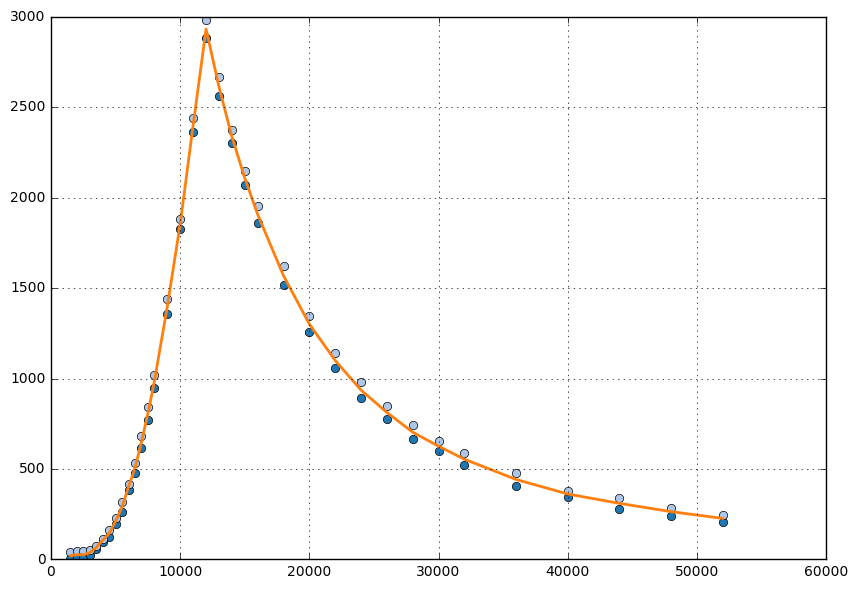

In [130]:
# Plot prices
bids = np.array([S*opt['bid'] for opt in OTM])
asks = np.array([S*opt['ask'] for opt in OTM])
strikes = np.array([opt['strike'] for opt in OTM])

clean_bids = [i for i in range(len(bids)) if bids[i] != 0]
clean_asks = [i for i in range(len(asks)) if asks[i] != 0]
clean_mids = [i for i in range(len(asks)) if i in clean_bids and i in clean_asks]

plot(strikes, bids, 'o')
plot(strikes, asks, 'o')
plot(strikes, 0.5*(bids+asks))

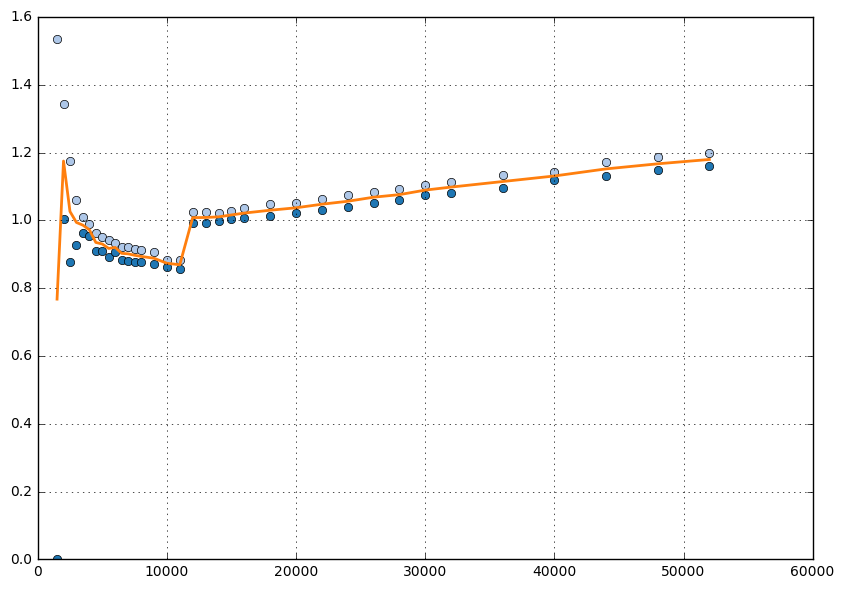

In [131]:
# Plot vols
plot(strikes, bid_vols, 'o')
plot(strikes, ask_vols, 'o')
plot(strikes, 0.5*(bid_vols+ask_vols))

In [132]:
# Fit surface
log_strikes = np.log(strikes/S)
max_strike = [i for i in range(len(log_strikes)) if log_strikes[i] >= np.log(2)][0]
p = opt.curve_fit(Sigma_explicit, log_strikes[:max_strike], 0.5*(bid_vols[:max_strike]+ask_vols[:max_strike]))[0]
p

array([ 0.9625257 , -0.08180025,  0.04993167])

(0, 2.0)

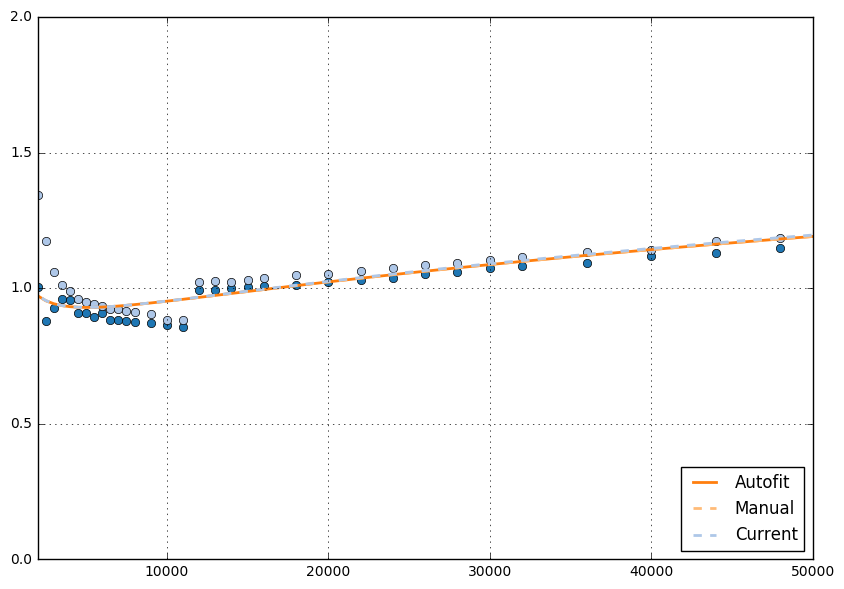

In [135]:
# Plot surface, show tweaks
pATM_shift  = 0.00
pSKEW_shift = 0.00
pVoV_shift  = 0.00

x = strikes

plot(x[clean_bids], bid_vols[clean_bids], 'o')
plot(x[clean_asks], ask_vols[clean_asks], 'o')

# Autofit
plot(x, Sigma_explicit(log_strikes,p[0],p[1],p[2]), label='Autofit')

# Modified autofit
plot(x, Sigma_explicit(log_strikes,p[0]+pATM_shift,p[1]+pSKEW_shift,p[2]+pVoV_shift), '--', label='Manual')

# Existing surface
plot(x, Sigma(log_strikes,my_surface[expiries(OTM[0]['expiration'])]), '--', color=tableau[1], label='Current')

legend(loc='lower right')
xlim(2000,50000)
ylim(0,2.00)

In [15]:
# Save my surface
my_surface_slice = [p[0]+pATM_shift, p[1]+pSKEW_shift, p[2]+pVoV_shift]
my_surface[expiry] = my_surface_slice
my_surface

NameError: name 'p' is not defined

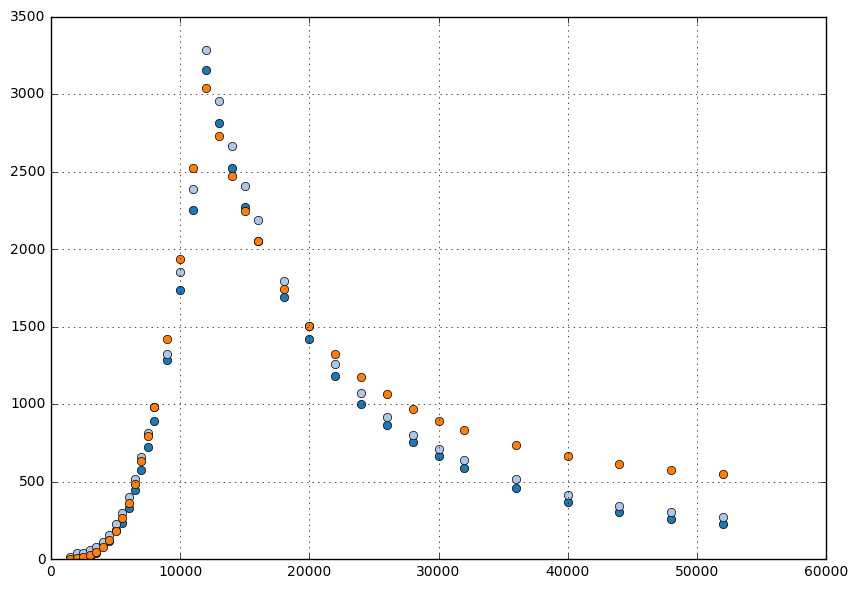

In [45]:
my_prices = np.zeros(len(strikes))
for i in range(len(strikes)):
    sigma = Sigma(np.log(strikes[i]/S), my_surface_slice)
    if strikes[i] <= S:
        my_prices[i] = BSput(S, strikes[i], T, sigma, 0.0, 0.0)
    else:
        my_prices[i] = BScall(S, strikes[i], T, sigma, 0.0, 0.0)

plot(strikes[clean_bids], bids[clean_bids], 'o')
plot(strikes[clean_asks], asks[clean_asks], 'o')
plot(strikes, my_prices, 'o')

In [17]:
#my_surface = {}
codes = list(set([expiries(inst['expiration']) for inst in instruments if inst['kind'] == 'option']))
for expiry in codes:
    autofit(expiry)

fitting 27DEC19 from 35 mids
fitting 23AUG19 from 18 mids
fitting 27SEP19 from 32 mids
fitting 30AUG19 from 20 mids


In [18]:
S = client.index()['btc']
S

10376.48

In [19]:
portfolio = { 
    'BTC-27SEP19-20000-C': -1.00,
    'BTC-27SEP19-30000-C':  1.00,
    'BTC-27SEP19-4000-P':   1.00,
    
    'BTC-27DEC19-30000-C': -1.00,
    
    'BTC-27DEC19-0.01-C':   0.25}
options = list(portfolio.keys())

In [20]:
quantities = np.array(list(portfolio.values()))
overrides = {'spot': S, 'vol_shift': 0.0, 'time_shift': -0/365}
values = np.array([PV(opt, my_surface, overrides) for opt in options])
deltas = np.array([delta(opt, my_surface, overrides) for opt in options])
gammas = np.array([gamma(opt, my_surface, overrides) for opt in options])
vegas = np.array([vega(opt, my_surface, overrides) for opt in options])
thetas = np.array([theta(opt, my_surface, overrides) for opt in options])

In [21]:
df = pd.DataFrame(columns=['Px','Q','PV','Delta','Gamma','Vega','Theta'])
for idx in range(len(options)):
    instrument = options[idx]
    row = pd.Series()
    row['Expiry'] = instrument.split('-')[1]
    row['PutCall'] = 'call' if instrument.split('-')[3] == 'C' else 'put'
    row['Strike'] = float(instrument.split('-')[2])
    row['Px'] = round(values[idx],2)
    row['Q']  = quantities[idx]
    row['PV']    = values[idx]*row['Q']
    row['Delta'] = deltas[idx]*row['Q']
    row['Gamma'] = gammas[idx]*row['Q']
    row['Vega']  = vegas[idx]*row['Q']
    row['Theta'] = thetas[idx]*row['Q']
    row['Vol'] = Sigma(np.log(float(instrument.split('-')[2])/S), my_surface[instrument.split('-')[1]])*100
    row['Vol'] = nan if row['Vol'] > 1000 else row['Vol']
    row.name = instrument
    df = df.append(row)
total = df.sum()
total.name = 'total'
total['Expiry'] = ''
total['PutCall'] = ''
total['Strike'] = ''
total['Px'] = S
total['Vol'] = nan
df = df.append(total)[['Expiry','Strike','PutCall','PV','Q','Delta','Gamma','Vega','Theta','Vol','Px']]
df = df.sort_values(['Expiry','Strike'])

In [ ]:
def color_negpos(val):
    color = 'red' if val < 0 else 'blue'
    return 'color: %s' % color
df.style.\
    applymap(color_negpos,subset=['PV','Q','Delta','Gamma','Vega','Theta']).\
    format({'PV': '{:>.2f}', 'Delta': '{:>.2f}', 'Gamma': '{:>.2f}', 'Vega': '{:>.2f}', 'Theta': '{:>.2f}',
                 'Q': '{:>.1f}', 'Vol': '{:>.1f}', 'Px': '{:>,.2f}'})

In [408]:
spot_s = 0.50*S; spot_e = 1.5*S
spots = np.arange(int((spot_e - spot_s)/50))*50 + spot_s
values = [(quantities*np.array([PV(opt, my_surface, overrides={'spot': s, 'time_shift': -1/365}) 
          for opt in portfolio])).sum() for s in spots]

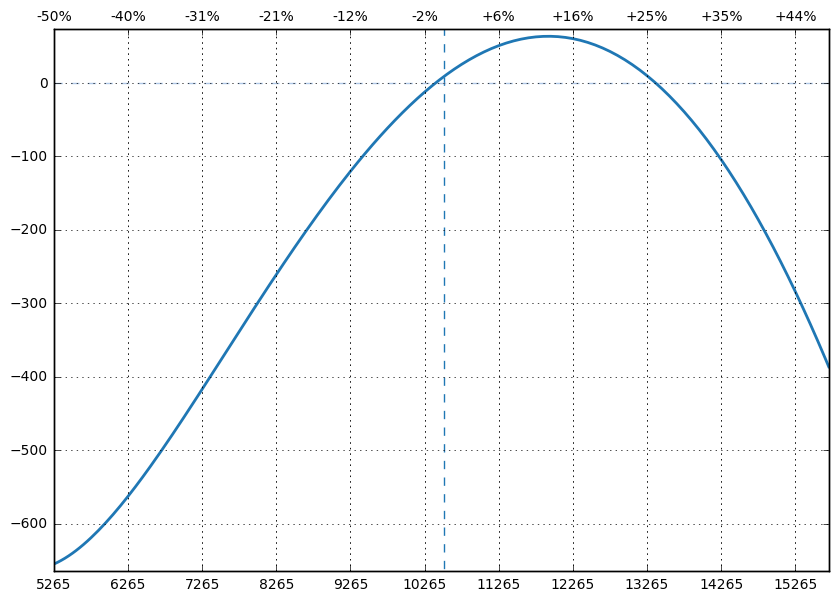

In [409]:
hedge = 0.00
pnl = values-df.loc['total'].PV + hedge*(spots-S)
plot([S,S], [np.min(pnl)-100, np.max(pnl)+100], '--', lw=1)
plot([spots[0],spots[-1]],[0.0,0.0], '--', lw=1)
plot(spots, pnl, color=tableau[0])
ylim(np.min(pnl)-10,np.max(pnl)+10)
xlim(spots[0],spots[-1]);

ticks = np.arange(int((spot_e-spot_s)/1000)+1)*1000+spot_s
xticks(ticks)

ax2 = twiny()
ax2.set_xlim(spots[0],spots[-1])
ax2.set_xticks(ticks)
ax2.set_xticklabels(['%s%d%%'%('' if t < 0 else '+',100*t) for t in ticks/S-1]);

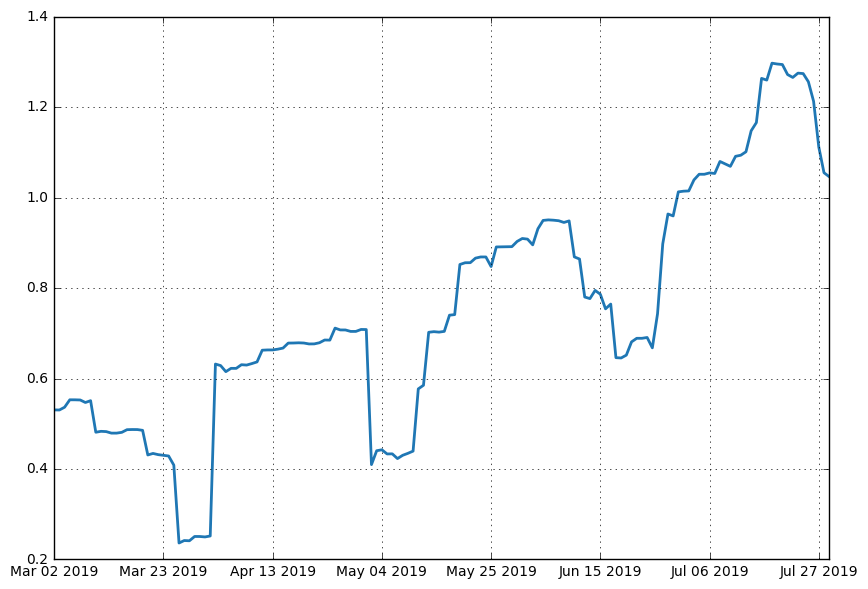

In [389]:
plot(get_historical_vol(30))

In [268]:
expiry_table = pd.DataFrame()
expiry_table = expiry_table.assign(code=codes,date=pd.to_datetime([code_to_expiry(code) for code in codes]))
expiry_table = expiry_table.sort_values('date')

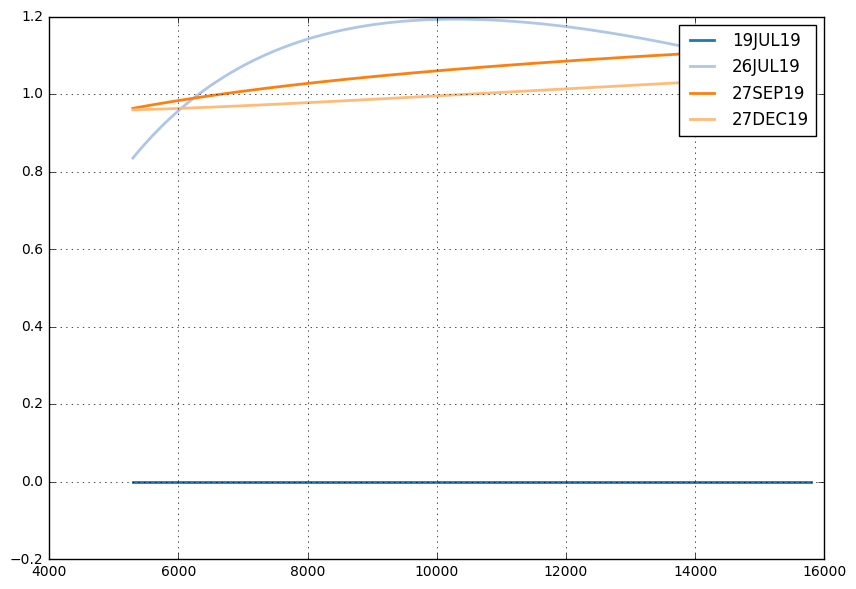

In [269]:
strikes = np.log(spots/S)
for code in expiry_table.code:
    plot(np.exp(strikes)*S, Sigma(strikes,my_surface[code]), label=code)
legend(loc='upper right')

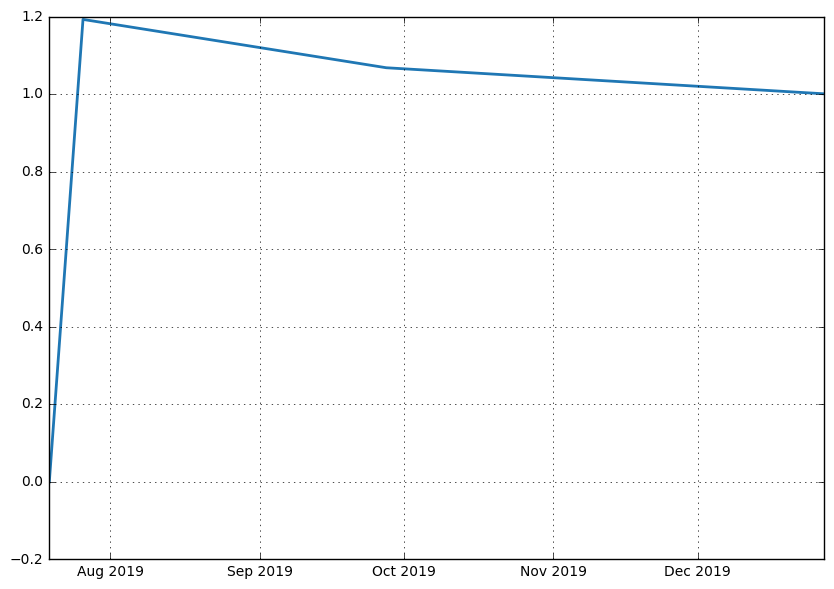

In [270]:
plot(expiry_table.date, [Sigma(0,my_surface[code]) for code in expiry_table.code])